# Imports

In [73]:
from pathlib import Path
import random
import os

import numpy as np
from tifffile import TiffFile
from tifffile import imread
import matplotlib.pyplot as plt
from tqdm import tqdm

from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset

from sklearn.model_selection import train_test_split

# Fonctions utiles

In [48]:
class LCD():
    """Class to represent the S2GLC Land Cover Dataset for the challenge,
    with useful metadata and statistics.
    """
    # image size of the images and label masks
    IMG_SIZE = 256
    # the images are RGB+NIR (4 channels)
    N_CHANNELS = 4
    # we have 9 classes + a 'no_data' class for pixels with no labels (absent in the dataset)
    N_CLASSES = 10
    CLASSES = [
        'no_data',
        'clouds',
        'artificial',
        'cultivated',
        'broadleaf',
        'coniferous',
        'herbaceous',
        'natural',
        'snow',
        'water'
    ]
    # classes to ignore because they are not relevant. "no_data" refers to pixels without
    # a proper class, but it is absent in the dataset; "clouds" class is not relevant, it
    # is not a proper land cover type and images and masks do not exactly match in time.
    IGNORED_CLASSES_IDX = [0, 1]

    # The training dataset contains 18491 images and masks
    # The test dataset contains 5043 images and masks
    TRAINSET_SIZE = 18491
    TESTSET_SIZE = 5043

    # for visualization of the masks: classes indices and RGB colors
    CLASSES_COLORPALETTE = {
        0: [0,0,0],
        1: [255,25,236],
        2: [215,25,28],
        3: [211,154,92],
        4: [33,115,55],
        5: [21,75,35],
        6: [118,209,93],
        7: [130,130,130],
        8: [255,255,255],
        9: [43,61,255]
        }
    CLASSES_COLORPALETTE = {c: np.asarray(color) for (c, color) in CLASSES_COLORPALETTE.items()}

    # statistics
    # the pixel class counts in the training set
    TRAIN_CLASS_COUNTS = np.array(
        [0, 20643, 60971025, 404760981, 277012377, 96473046, 333407133, 9775295, 1071, 29404605]
    )
    # the minimum and maximum value of image pixels in the training set
    TRAIN_PIXELS_MIN = 1
    TRAIN_PIXELS_MAX = 24356

In [49]:
def numpy_parse_image(image_path):
    """Load an image and its segmentation mask as numpy arrays and returning a tuple
    Args:
        image_path (bytes): path to image
    Returns:
        (numpy.array[uint16], numpy.array[uint8]): the image and mask arrays
    """
    image_path = Path(bytes.decode(image_path))
    # get mask path from image path:
    # image should be in a images/<image_id>.tif subfolder, while the mask is at masks/<image_id>.tif
    mask_path = image_path.parent.parent/'masks'/image_path.name
    with TiffFile(image_path) as tifi, TiffFile(mask_path) as tifm:
        image = tifi.asarray()
        mask = tifm.asarray()
        # add channel dimension to mask: (256, 256, 1)
        mask = mask[..., None]
    return image, mask

In [42]:
def show_image(image, display_min=50, display_max=400, ax=None):
    """Show an image.
    Args:
        image (numpy.array[uint16]): the image. If the image is 16-bit, apply bytescaling to convert to 8-bit
    """
    if image.dtype == np.uint16:
        iscale = display_max - display_min
        scale = 255 / iscale
        byte_im = (image) * scale
        byte_im = (byte_im.clip(0, 255) + 0.5).astype(np.uint8)
        image = byte_im
    # show image
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    ax.axis("off")
    im = ax.imshow(image)
    return im

def show_mask(mask, classes_colorpalette, classes=None, add_legend=True, ax=None):
    """Show a a semantic segmentation mask.
    Args:
       mask (numpy.array[uint8]): the mask in 8-bit
       classes_colorpalette (dict[int, tuple]): dict mapping class index to an RGB color in [0, 1]
       classes (list[str], optional): list of class labels
       add_legend
    """
    show_mask = np.empty((*mask.shape, 3))
    for c, color in classes_colorpalette.items():
        show_mask[mask == c, :] = color
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis("off")
    im = ax.imshow(show_mask)
    if add_legend:
        # show legend mapping pixel colors to class names
        import matplotlib.patches as mpatches
        handles = []
        for c, color in classes_colorpalette.items():
            handles.append(mpatches.Patch(color=color, label=classes[c]))
        ax.legend(handles=handles)
    return im

# Visualisation

In [43]:
DATA_FOLDER_STR = 'D:/my_git/landscape_data/'
DATA_FOLDER = Path(DATA_FOLDER_STR).expanduser()
DATASET_FOLDER = DATA_FOLDER/'dataset'

# get all train images and masks
train_images_paths = sorted(list(DATASET_FOLDER.glob('train/images/*.tif')))
train_masks_paths = sorted(list(DATASET_FOLDER.glob('train/masks/*.tif')))
test_images_paths = sorted(list(DATASET_FOLDER.glob('test/images/*.tif')))

Taille de l'image :  (256, 256, 4)
Taille du masque :  (256, 256)


Text(0.5, 1.0, 'Mask')

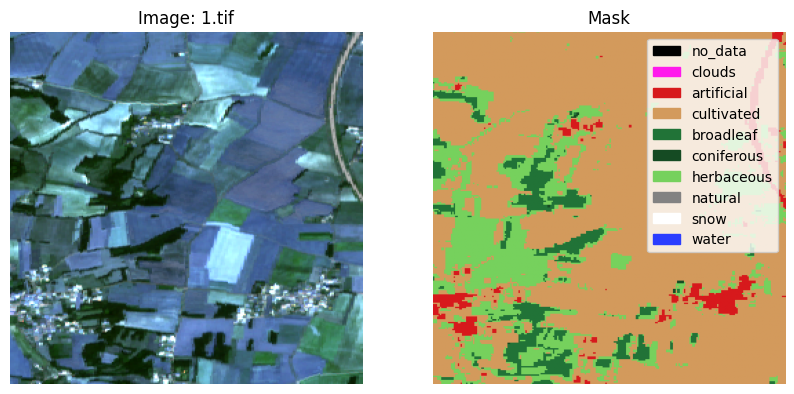

In [50]:
image_path = train_images_paths[0]
mask_path = train_masks_paths[0]

with TiffFile(image_path) as tif:
    arr = tif.asarray()    
    print("Taille de l'image : ", np.shape(arr))    
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
show_image(arr, display_min=0, display_max=2200, ax=axs[0])

with TiffFile(mask_path) as tif:
    arr = tif.asarray()
    print("Taille du masque : ", np.shape(arr))
classes_colorpalette = {c: color/255. for (c, color) in LCD.CLASSES_COLORPALETTE.items()}
show_mask(arr,
            classes_colorpalette = classes_colorpalette,
            classes=LCD.CLASSES,
            ax=axs[1]
)
axs[0].set_title(f'Image: {image_path.name}')
axs[1].set_title('Mask')

# Dataset 

In [53]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Décodage
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.bottleneck(x1)
        x3 = self.decoder(x2)

        return x3

In [58]:
# Chemins vers les dossiers d'images et de masques
images_folder = "D:/my_git/landscape_data/dataset/train/images/"
masks_folder = "D:/my_git/landscape_data/dataset/train/masks/"

# Liste pour stocker les chemins des fichiers d'images et de masques
image_paths = []
mask_paths = []

# Parcourir les fichiers dans le dossier d'images
for filename in os.listdir(images_folder):
    if filename.endswith(".tif"):
        image_path = os.path.join(images_folder, filename)        
        # Vérifier si le fichier de masque correspondant existe
        if os.path.exists(image_path):
            image_paths.append(image_path)

for filename in os.listdir(masks_folder):
    if filename.endswith(".tif"):
        mask_path = os.path.join(masks_folder, filename)        
        # Vérifier si le fichier de masque correspondant existe
        if os.path.exists(mask_path):
            mask_paths.append(mask_path)


In [60]:
# Diviser les données en ensembles d'entraînement et de validation
images_train, images_val, masks_train, masks_val = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

In [83]:
# Créer des tenseurs pour les ensembles d'entraînement et de validation
X_train = torch.stack([torch.tensor(imread(img).astype('float32'), dtype=torch.float32) for img in images_train], dim=0)
X_val = torch.stack([torch.tensor(imread(img).astype('float32'), dtype=torch.float32) for img in images_val], dim=0)

# Convertir les masques en tensors PyTorch avec le bon type de données
y_train = torch.stack([torch.tensor(imread(mask).astype('float32'), dtype=torch.float32) for mask in masks_train], dim=0)
y_val = torch.stack([torch.tensor(imread(mask).astype('float32'), dtype=torch.float32) for mask in masks_val], dim=0)

# Créer des ensembles de données PyTorch
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Créer des chargeurs de données
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

KeyboardInterrupt: 

In [ ]:

# Initialiser le modèle
in_channels = 4
out_channels = 3
model = UNet(in_channels, out_channels)

# Définir la fonction de perte et l'optimiseur
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs_val, targets_val in val_loader:
            outputs_val = model(inputs_val)
            val_loss += criterion(outputs_val, targets_val)

        average_val_loss = val_loss / len(val_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {average_val_loss:.4f}')
